In [ ]:
# Luke: define system-specific file paths here

local_var = 'TS'

DATAPATH_cesm  =    '/Users/lukeaparsons/Documents/Data/CESM/CESM_LME/'+str(local_var)+'/'

SAVEPATH  =    '/Users/lukeaparsons/python/SEOFs/output/'
FIGUREPATH  =  '/Users/lukeaparsons/python/SEOFs/figures/'

In [2]:
# Import modules
import utils #utils file with functions
import warnings
warnings.filterwarnings('ignore')
import os
import glob
import numpy as np
import xarray as xr
import xesmf as xe
from scipy import stats
from scipy import signal
import time
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature
from cartopy.util import add_cyclic_point
%matplotlib inline
import cartopy.util as cutil
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from mpl_toolkits.axes_grid1 import AxesGrid
from mpl_toolkits.basemap import Basemap, maskoceans
import matplotlib.cm as cm

import utils

In [3]:
# find all files that have necessary start/end strings etc for the all-forcing run
filenames = sorted(os.listdir(DATAPATH_cesm))
filenames_cesm = {}
h = 0
for filename in sorted(os.listdir(DATAPATH_cesm)):
    if filename.endswith(".cam.h0.TS.085001-184912.nc"): #note this picks data 850-1849
        if filename.startswith("b.e11.BLMTRC5CN.f19_g16.0"): #note this string is the string for the all forcing data set
            #print("filename starts with: b.e11.BLMTRC5CN.f19_g16.0")
            #print(filename)
            filenames_cesm[h] = filename
            h = h + 1
filenames_cesm
nens = h

In [4]:
#load control run to determine lat, lon, nt, etc.
ds = xr.open_dataset(DATAPATH_cesm + 'b.e11.B1850C5CN.f19_g16.0850cntl.001.cam.h0.TS.085001-184912.nc') #load tas
LAT = ds['lat'][:]
LON = ds['lon'][:]
ds_TS = ds['TS'][:,:,:]
ds_TS = ds_TS.groupby('time.year').mean('time')
ds_TS = ds_TS[0:1000,:,:]
[nt,nlat,nlon] = np.shape(ds_TS);
print(nt,nlat,nlon)

CESM_cntl_anoms = ds_TS - ds_TS.mean(axis=0)
CESM_cntl_ltm = ds_TS.mean(axis=0)
CESM_cntl_anoms_weighted = utils.weightdata(ds,CESM_cntl_anoms) #use function to latitude weight data
print('CESM control shape is: ',CESM_cntl_anoms_weighted.shape)

1000 96 144
CESM control shape is:  (1000, 96, 144)
Dimensions of U are: (13824, 1000) , Dimensions of S are:  (1000,) , Dimensions of V are:  (1000, 1000)


array([8.79, 4.61, 4.16, 3.04, 2.7 , 2.05, 1.89, 1.79, 1.6 ])

In [23]:
#now calculate SVD of control run
CESM_cntl_anoms_weighted_reshaped = np.reshape(CESM_cntl_anoms_weighted.values,(nt,nlon*nlat))
[U,S,V] = np.linalg.svd(CESM_cntl_anoms_weighted_reshaped.T,full_matrices=False) #note I'm transposing to put the space dimension first!
print('Dimensions of U are:',U.shape,', Dimensions of S are: ',S.shape,', Dimensions of V are: ',V.shape)
#reshape the SVD output, calculate % variance explained
U_reshaped = np.reshape(U,(nlat,nlon,nt))
S_sq = np.square(S)
S_Sum = np.nansum(S_sq)
EOF_PVar = np.round(np.divide(S_sq,S_Sum)*100,2);
EOF_PVar_cumsum = np.cumsum(EOF_PVar)
EOF_PVar[0:9]

Dimensions of U are: (13824, 1000) , Dimensions of S are:  (1000,) , Dimensions of V are:  (1000, 1000)


array([28.4 ,  8.79,  4.61,  4.16,  3.04,  2.7 ,  2.05,  1.89,  1.79])

Text(0.5, 1.0, 'CESM piControl SVD Cumul. % Variance')

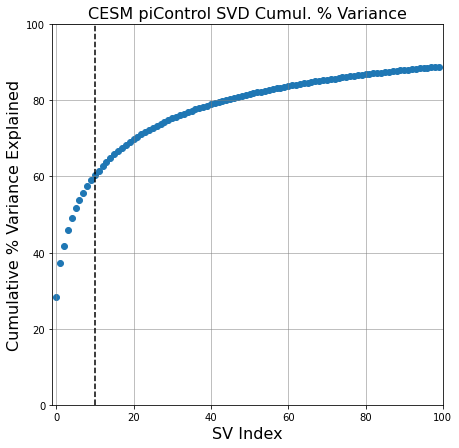

In [46]:
#plot cumulative sum of variance
fig = plt.figure(figsize=(7,7))
plt.scatter(np.arange(0,100,1),EOF_PVar_cumsum[0:100])
plt.grid(color='grey', linestyle='-', linewidth=0.5)
plt.vlines(10,0,100, colors='k', linestyles='dashed')
plt.xlim([-1,100])
plt.ylim([0,100])
plt.xlabel('SV Index',fontsize=16)
plt.ylabel('Cumulative % Variance Explained',fontsize=16)
plt.title('CESM piControl SVD Cumul. % Variance',fontsize=16)

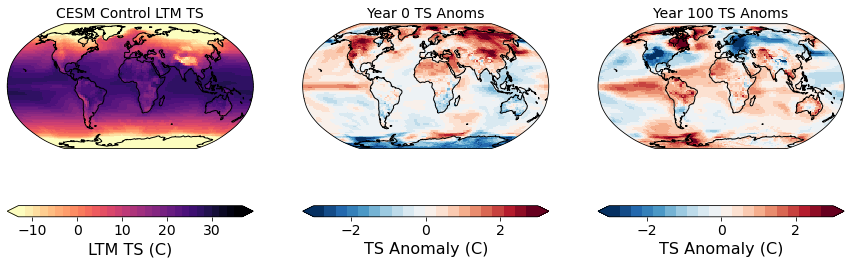

In [51]:
# plot control run background mean climatology, one year of anomalies from climatology to check data

fig = plt.figure(figsize=(15,7))

ax = plt.subplot(1,3,1,projection = ccrs.Robinson(central_longitude=0))
ax.set_global()
ax.coastlines(resolution='110m', linewidth=1)
plotvalue = CESM_cntl_ltm-273.15
im = plt.pcolormesh(LON,LAT,plotvalue,cmap=plt.cm.get_cmap('magma_r',30),transform=ccrs.PlateCarree())
plt.clim(260-273.15, 310-273.15)
plt.title('CESM Control LTM TS',fontsize=14,ha='center')
cbar=plt.colorbar(extend='both',orientation='horizontal',shrink=1) #plot colorbar
cbar.ax.tick_params(labelsize=14)
cbar.set_label('LTM TS (C)',fontsize=16)

ax = plt.subplot(1,3,2,projection = ccrs.Robinson(central_longitude=0))
ax.set_global()
ax.coastlines(resolution='110m', linewidth=1)
plotvalue = CESM_cntl_anoms[0,:,:]
im = plt.pcolormesh(LON,LAT,plotvalue,cmap=plt.cm.get_cmap('RdBu_r',20),transform=ccrs.PlateCarree())
plt.clim(-3, 3)
plt.title('Year 0 TS Anoms',fontsize=14,ha='center')
cbar=plt.colorbar(extend='both',orientation='horizontal',shrink=1) #plot colorbar
cbar.ax.tick_params(labelsize=14)
cbar.set_label('TS Anomaly (C)',fontsize=16)

ax = plt.subplot(1,3,3,projection = ccrs.Robinson(central_longitude=0))
ax.set_global()
ax.coastlines(resolution='110m', linewidth=1)
plotvalue = CESM_cntl_anoms[100,:,:]
im = plt.pcolormesh(LON,LAT,plotvalue,cmap=plt.cm.get_cmap('RdBu_r',20),transform=ccrs.PlateCarree())
plt.clim(-3, 3)
plt.title('Year 100 TS Anoms',fontsize=14,ha='center')
cbar=plt.colorbar(extend='both',orientation='horizontal',shrink=1) #plot colorbar
cbar.ax.tick_params(labelsize=14)
cbar.set_label('TS Anomaly (C)',fontsize=16)

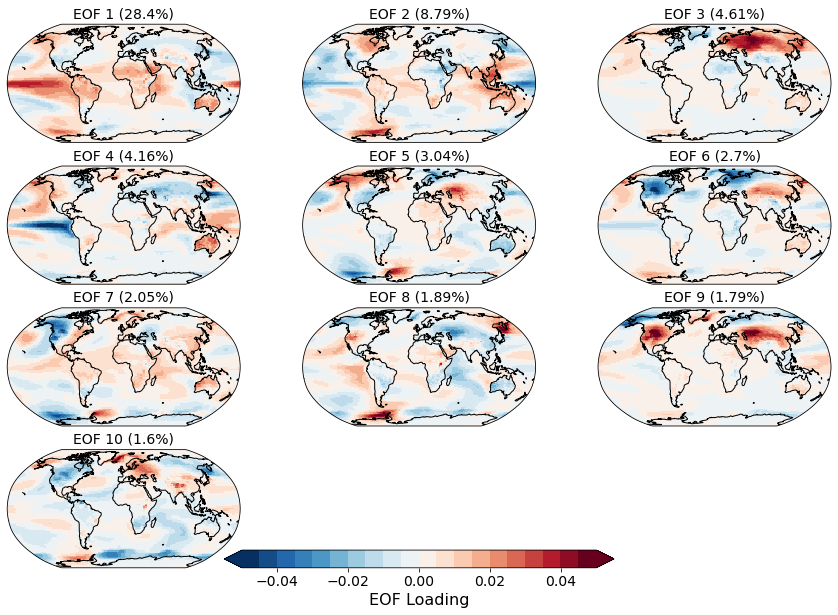

In [52]:
#plot the EOF loading
fig = plt.figure(figsize=(15,10))

neofs = 10
for p in np.arange(0,neofs,1):
    ax = plt.subplot(4,3,p+1,projection = ccrs.Robinson(central_longitude=0))
    ax.set_global()
    ax.coastlines(resolution='110m', linewidth=1)
    plotvalue = U_reshaped[:,:,p]
    im = plt.pcolormesh(LON,LAT,plotvalue,cmap=plt.cm.get_cmap('RdBu_r',20),transform=ccrs.PlateCarree())
    plt.clim(-.05, .05)
    plt.title('EOF ' + str(p+1)+' (' + str(EOF_PVar[p]) + '%)',fontsize=14,ha='center')
    
ax = plt.subplot(4,3,p+2)
ax.axis('off')
cbar=plt.colorbar(extend='both',orientation='horizontal',shrink=1.5) #plot colorbar
cbar.ax.tick_params(labelsize=14)
cbar.set_label('EOF Loading',fontsize=16)

In [53]:
CESM_All13_RemLTM = np.empty([nt,nlat,nlon,nens])
CESM_All13_RemLTM_Weighted = np.empty([nt,nlat,nlon,nens])

for f in filenames_cesm:
    start0 = time.time() #keep track of time through for loop
    ds = xr.open_dataset(DATAPATH_cesm + filenames_cesm[f]) #load cesm data defined above
    lat = ds['lat'][:]
    lon = ds['lon'][:]
    data_TS = ds['TS'][:,:,:]
    data_TS = data_TS.groupby('time.year').mean('time')
    data_TS = data_TS[0:nt,:,:] #note that data includes first month of 1850, so exclude 1850!
    data_TS_ltm = data_TS.mean(axis=0)
    data_TS_anom = data_TS - data_TS_ltm
    #print(data_TS_anom.shape)
    data_TS_anom_weighted = utils.weightdata(ds,data_TS_anom) #use function to latitude weight data
    GM = utils.simple_spatial_average(data_TS_anom, lat_bounds=[-90, 90], lon_bounds=[0, 360])
    #plt.plot(GM['year'],GM)
    #save at end of for loop
    CESM_All13_RemLTM[:,:,:,f] = data_TS_anom
    CESM_All13_RemLTM_Weighted[:,:,:,f] = data_TS_anom_weighted
    print("Done with loading, all calcs in ",round(time.time() - start0)," seconds")

Done with loading, all calcs in  2  seconds
Done with loading, all calcs in  3  seconds
Done with loading, all calcs in  3  seconds
Done with loading, all calcs in  3  seconds
Done with loading, all calcs in  3  seconds
Done with loading, all calcs in  3  seconds
Done with loading, all calcs in  3  seconds
Done with loading, all calcs in  3  seconds
Done with loading, all calcs in  3  seconds
Done with loading, all calcs in  3  seconds
Done with loading, all calcs in  3  seconds
Done with loading, all calcs in  5  seconds
Done with loading, all calcs in  5  seconds


In [60]:
import ens_snapshot_tools

IndentationError: unindent does not match any outer indentation level (ens_snapshot_tools.py, line 75)